In [1]:
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = '../data'
results_dir = '../results'
task = 'by_timepoint'

task_data_dir = data_dir
task_results_dir = os.path.join(results_dir, task)

if not os.path.exists(task_results_dir):
    os.makedirs(task_results_dir)

In [3]:
# Set a random seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the MLP model
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x

# Function to calculate accuracy
def calculate_mae(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    _, actual = torch.max(labels, 1)
    # mean absolute error
    correct = (predicted - actual).abs().sum().item()
    return correct / labels.size(0)

def train_mlp(input_data, labels, val_data, val_labels, hidden_size=10, learning_rate=0.01, epochs=100, seed=42, gpu_device=None, l2_lambda=0.01, depth="shallow", print_step=100):
    # Set the seed for reproducibility
    set_seed(seed)

    # Set device to the specified GPU if available, otherwise CPU
    if gpu_device is not None and torch.cuda.is_available():
        device = torch.device(f"cuda:{gpu_device}")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    input_size = input_data.shape[1]
    output_size = labels.shape[1]

    # Initialize the model, loss function, and optimizer
    if depth == "shallow":
        model = MLP(input_size, hidden_size, output_size).to(device)
    elif depth == "deep":
        model = DeepMLP(input_size, hidden_size, output_size).to(device)
    else:
        raise Exception("Error in model depth provided.")
    
    criterion = nn.MSELoss()  # Assuming we're doing regression, adjust for classification if needed
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)  # L2 regularization added via weight_decay

    # Convert input data and validation data to PyTorch tensors and move to device
    input_tensor = torch.FloatTensor(input_data).to(device)
    labels_tensor = torch.FloatTensor(labels).to(device)
    val_tensor = torch.FloatTensor(val_data).to(device)
    val_labels_tensor = torch.FloatTensor(val_labels).to(device)

    # Lists to store training and validation losses
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    # Training loop
    for epoch in range(epochs):
        # Forward pass on training data
        model.train()
        outputs = model(input_tensor)
        loss = criterion(outputs, labels_tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store training loss
        training_losses.append(loss.item())

        # Calculate training accuracy
        train_mae = calculate_mae(outputs, labels_tensor)
        training_accuracies.append(train_mae)

        # Evaluate on the validation set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_outputs = model(val_tensor)
            val_loss = criterion(val_outputs, val_labels_tensor)

        # Store validation loss
        validation_losses.append(val_loss.item())

        # Calculate validation accuracy
        val_mae = calculate_mae(val_outputs, val_labels_tensor)
        validation_accuracies.append(val_mae)

        if (epoch + 1) % print_step == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}')
        
    return {"model": model,
            "training_losses": training_losses,
            "validation_losses": validation_losses,
            "training_acc": training_accuracies,
            "validation_acc": validation_accuracies}

# Function to evaluate the MLP on a test set
def evaluate_mlp(model, test_data, test_labels, device):
    model.eval()
    test_tensor = torch.FloatTensor(test_data).to(device)
    test_labels_tensor = torch.FloatTensor(test_labels).to(device)
    criterion = nn.MSELoss()

    with torch.no_grad():
        test_outputs = model(test_tensor)
        test_loss = criterion(test_outputs, test_labels_tensor)
        test_accuracy = calculate_mae(test_outputs, test_labels_tensor)

    print(f'Test Loss: {test_loss.item():.4f}, Test MAE: {test_accuracy:.4f}')

    return (test_loss.item(), test_accuracy, test_outputs.to('cpu'))

In [4]:
# # Example usage:
# # 2D input vectors and 2D output labels for training
# input_data = np.array([[0.5, 0.3, 0], [0.5, 0.3, 1], [0.9, 0.1, 0], [0.7, 0.6, 0]])
# labels = np.array([[0.5, 0.3], [0.4, 0.7], [0.3, 0.2], [0.6, 0.9]])

# # 2D validation vectors and 2D output labels for validation
# val_data = np.array([[0.4, 0.2, 0], [0.3, 0.9, 1]])
# val_labels = np.array([[0.2, 0.4], [0.5, 0.6]])

# # Train the MLP and track validation loss
# results = train_mlp(input_data, labels, val_data, val_labels, hidden_size=5, learning_rate=0.01, epochs=100, seed=42, gpu_device=3)

In [5]:
def build_data(csv_files):
    inputs_list = list()
    outputs_list = list()

    for file in csv_files:
        df = pd.read_csv(file)
        initial_conditions = np.tile(df[df["Time"]==0][["Prey", "Predator"]].to_numpy()[0], (df.shape[0], 1))
        times = df["Time"].to_numpy().reshape(-1,1)
        inputs_list.append( np.hstack((initial_conditions, times)) )
        outputs_list.append( df[["Prey","Predator"]].to_numpy() )

    inputs = np.vstack(inputs_list)
    outputs = np.vstack(outputs_list)

    return inputs, outputs

data_files = [f for f in os.listdir(task_data_dir) if f.endswith('csv') and f.startswith('predator')]

training_indices = list(range(0,70)) # [0,1,2,3]
validation_indices = list(range(70, 95)) # [4,5,6,7]
testing_indices = list(range(95, 109)) # [8,9]

# Set up training data
train_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in training_indices]
training_inputs, training_outputs = build_data(train_csv_files)
training_data = {
    'inputs': training_inputs,
    'labels': training_outputs
}
print(training_data['inputs'].shape)

# Set up validaiton data
valid_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in validation_indices]
valid_inputs, valid_outputs = build_data(valid_csv_files)
validation_data = {
    'inputs': valid_inputs,
    'labels': valid_outputs
}
print(validation_data['inputs'].shape)

# Set up testing data
test_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in testing_indices]
test_inputs, test_outputs = build_data(test_csv_files)
testing_data = {
    'inputs': test_inputs,
    'labels': test_outputs
}
print(testing_data['inputs'].shape)

# split_string = f"{','.join(map(str,training_indices))}:{','.join(map(str,validation_indices))}:{','.join(map(str,testing_indices))}"
split_string = f"{training_indices[0]}-{training_indices[-1]}:{validation_indices[0]}-{validation_indices[-1]}:{testing_indices[0]}-{testing_indices[-1]}"
print(split_string)

(70000, 3)
(25000, 3)
(14000, 3)
0-69:70-94:95-108


In [6]:
epochs = 1_000_000
seed = 42
l2_lambda = 0.01
lr = 0.01
hidden_size=100
depth = "deep"
gpu_device = 2
suffix = f"{epochs}-{seed}-{l2_lambda}-{lr}-{hidden_size}-{depth}-{split_string}"

In [7]:
# Train!
results = train_mlp(training_data['inputs'], 
                  training_data['labels'], 
                  validation_data['inputs'], 
                  validation_data['labels'], 
                  hidden_size=hidden_size, 
                  learning_rate=lr, 
                  epochs=epochs, 
                  seed=seed,
                  gpu_device=gpu_device,
                  l2_lambda=l2_lambda,
                  depth=depth,
                  print_step=10_000)

# Evaluate the model on the test set
test_loss, test_acc, test_outputs = evaluate_mlp(results["model"], testing_data['inputs'], testing_data['labels'], 
             device=torch.device(f"cuda:{gpu_device}") if torch.cuda.is_available() else torch.device("cpu"))

results['test_loss'] = test_loss
results['test_acc'] = test_acc

# Save the results as a pickled object
with open(os.path.join(task_results_dir, f'mlp_training_results_{suffix}.pkl'), 'wb') as f:
    pickle.dump(results, f)

Using device: cuda:2


Epoch [10000/1000000], Loss: 489.7157, Validation Loss: 469.4519, Train MAE: 0.3385, Val MAE: 0.3242


Epoch [20000/1000000], Loss: 459.4667, Validation Loss: 448.4542, Train MAE: 0.3253, Val MAE: 0.3148


Epoch [30000/1000000], Loss: 454.3766, Validation Loss: 446.6419, Train MAE: 0.3175, Val MAE: 0.3117


Epoch [40000/1000000], Loss: 433.8419, Validation Loss: 430.0437, Train MAE: 0.3107, Val MAE: 0.3043


Epoch [50000/1000000], Loss: 443.6253, Validation Loss: 444.7928, Train MAE: 0.3214, Val MAE: 0.3197


Epoch [60000/1000000], Loss: 421.2328, Validation Loss: 431.3199, Train MAE: 0.3030, Val MAE: 0.3016


Epoch [70000/1000000], Loss: 420.1850, Validation Loss: 428.7637, Train MAE: 0.3044, Val MAE: 0.3052


Epoch [80000/1000000], Loss: 421.6952, Validation Loss: 436.6285, Train MAE: 0.3218, Val MAE: 0.3060


Epoch [90000/1000000], Loss: 417.0644, Validation Loss: 422.9719, Train MAE: 0.2976, Val MAE: 0.2926


Epoch [100000/1000000], Loss: 415.2827, Validation Loss: 411.4431, Train MAE: 0.2943, Val MAE: 0.2922


Epoch [110000/1000000], Loss: 415.2337, Validation Loss: 413.7418, Train MAE: 0.3231, Val MAE: 0.2996


Epoch [120000/1000000], Loss: 411.8419, Validation Loss: 408.8857, Train MAE: 0.2957, Val MAE: 0.2910


Epoch [130000/1000000], Loss: 449.6092, Validation Loss: 433.8995, Train MAE: 0.3221, Val MAE: 0.3149


Epoch [140000/1000000], Loss: 453.2982, Validation Loss: 436.5790, Train MAE: 0.3253, Val MAE: 0.3161


Epoch [150000/1000000], Loss: 439.1646, Validation Loss: 423.0996, Train MAE: 0.3139, Val MAE: 0.3054


Epoch [160000/1000000], Loss: 441.1117, Validation Loss: 423.1826, Train MAE: 0.3107, Val MAE: 0.3029


Epoch [170000/1000000], Loss: 435.9684, Validation Loss: 418.5332, Train MAE: 0.3137, Val MAE: 0.2974


Epoch [180000/1000000], Loss: 434.2520, Validation Loss: 416.9789, Train MAE: 0.3085, Val MAE: 0.3045


Epoch [190000/1000000], Loss: 435.3079, Validation Loss: 417.5600, Train MAE: 0.3060, Val MAE: 0.2960


Epoch [200000/1000000], Loss: 434.9774, Validation Loss: 416.5689, Train MAE: 0.3167, Val MAE: 0.3132


Epoch [210000/1000000], Loss: 423.7360, Validation Loss: 406.2015, Train MAE: 0.3012, Val MAE: 0.2897


Epoch [220000/1000000], Loss: 421.5550, Validation Loss: 404.5955, Train MAE: 0.2963, Val MAE: 0.2862


Epoch [230000/1000000], Loss: 418.2068, Validation Loss: 401.1125, Train MAE: 0.2927, Val MAE: 0.2866


Epoch [240000/1000000], Loss: 416.9686, Validation Loss: 400.7658, Train MAE: 0.2991, Val MAE: 0.2861


Epoch [250000/1000000], Loss: 414.6512, Validation Loss: 399.2097, Train MAE: 0.2960, Val MAE: 0.2934


Epoch [260000/1000000], Loss: 413.4008, Validation Loss: 397.2679, Train MAE: 0.2988, Val MAE: 0.2861


Epoch [270000/1000000], Loss: 417.4121, Validation Loss: 401.3330, Train MAE: 0.2970, Val MAE: 0.2880


Epoch [280000/1000000], Loss: 444.6732, Validation Loss: 429.1485, Train MAE: 0.3111, Val MAE: 0.3021


Epoch [290000/1000000], Loss: 412.3074, Validation Loss: 399.3574, Train MAE: 0.2982, Val MAE: 0.2851


Epoch [300000/1000000], Loss: 428.1346, Validation Loss: 413.4059, Train MAE: 0.2973, Val MAE: 0.2890


Epoch [310000/1000000], Loss: 418.0422, Validation Loss: 404.4845, Train MAE: 0.2951, Val MAE: 0.2875


Epoch [320000/1000000], Loss: 415.9958, Validation Loss: 404.5874, Train MAE: 0.2954, Val MAE: 0.2870


Epoch [330000/1000000], Loss: 415.3527, Validation Loss: 402.5757, Train MAE: 0.3082, Val MAE: 0.2907


Epoch [340000/1000000], Loss: 416.3726, Validation Loss: 406.2803, Train MAE: 0.2961, Val MAE: 0.2900


Epoch [350000/1000000], Loss: 412.4337, Validation Loss: 402.5125, Train MAE: 0.2930, Val MAE: 0.2890


Epoch [360000/1000000], Loss: 434.1141, Validation Loss: 414.8020, Train MAE: 0.3066, Val MAE: 0.2944


Epoch [370000/1000000], Loss: 431.7327, Validation Loss: 412.9965, Train MAE: 0.3021, Val MAE: 0.2922


Epoch [380000/1000000], Loss: 431.7679, Validation Loss: 413.1780, Train MAE: 0.3063, Val MAE: 0.3067


Epoch [390000/1000000], Loss: 461.9568, Validation Loss: 442.2444, Train MAE: 0.3224, Val MAE: 0.3120


Epoch [400000/1000000], Loss: 452.1579, Validation Loss: 433.0248, Train MAE: 0.3108, Val MAE: 0.3011


Epoch [410000/1000000], Loss: 451.5198, Validation Loss: 432.1698, Train MAE: 0.3181, Val MAE: 0.3033


Epoch [420000/1000000], Loss: 449.7789, Validation Loss: 428.6720, Train MAE: 0.3056, Val MAE: 0.2971


Epoch [430000/1000000], Loss: 449.1762, Validation Loss: 428.7597, Train MAE: 0.3060, Val MAE: 0.2959


Epoch [440000/1000000], Loss: 444.6237, Validation Loss: 423.0093, Train MAE: 0.3198, Val MAE: 0.3036


Epoch [450000/1000000], Loss: 441.3784, Validation Loss: 421.7354, Train MAE: 0.3117, Val MAE: 0.2975


Epoch [460000/1000000], Loss: 439.2671, Validation Loss: 420.3595, Train MAE: 0.3057, Val MAE: 0.2960


Epoch [470000/1000000], Loss: 438.4929, Validation Loss: 419.1195, Train MAE: 0.3100, Val MAE: 0.2955


Epoch [480000/1000000], Loss: 437.0943, Validation Loss: 417.6020, Train MAE: 0.3044, Val MAE: 0.2952


Epoch [490000/1000000], Loss: 436.0856, Validation Loss: 416.9797, Train MAE: 0.3043, Val MAE: 0.2937


Epoch [500000/1000000], Loss: 435.7989, Validation Loss: 416.6271, Train MAE: 0.3042, Val MAE: 0.2944


Epoch [510000/1000000], Loss: 437.5506, Validation Loss: 418.1729, Train MAE: 0.3253, Val MAE: 0.3008


Epoch [520000/1000000], Loss: 460.5686, Validation Loss: 438.9978, Train MAE: 0.3249, Val MAE: 0.3196


Epoch [530000/1000000], Loss: 459.7389, Validation Loss: 437.8659, Train MAE: 0.3292, Val MAE: 0.3230


Epoch [540000/1000000], Loss: 458.4980, Validation Loss: 436.3766, Train MAE: 0.3303, Val MAE: 0.3096


Epoch [550000/1000000], Loss: 454.0806, Validation Loss: 432.4974, Train MAE: 0.3130, Val MAE: 0.3071


Epoch [560000/1000000], Loss: 453.4801, Validation Loss: 431.7869, Train MAE: 0.3125, Val MAE: 0.3046


Epoch [570000/1000000], Loss: 453.3515, Validation Loss: 431.9768, Train MAE: 0.3210, Val MAE: 0.3077


Epoch [580000/1000000], Loss: 453.0833, Validation Loss: 431.4485, Train MAE: 0.3115, Val MAE: 0.3043


Epoch [590000/1000000], Loss: 453.1863, Validation Loss: 431.4773, Train MAE: 0.3194, Val MAE: 0.3017


Epoch [600000/1000000], Loss: 453.1307, Validation Loss: 431.4782, Train MAE: 0.3119, Val MAE: 0.3084


Epoch [610000/1000000], Loss: 453.2028, Validation Loss: 431.3865, Train MAE: 0.3101, Val MAE: 0.3060


Epoch [620000/1000000], Loss: 473.2237, Validation Loss: 444.1256, Train MAE: 0.3475, Val MAE: 0.3184


Epoch [630000/1000000], Loss: 452.9973, Validation Loss: 431.1902, Train MAE: 0.3128, Val MAE: 0.3033


Epoch [640000/1000000], Loss: 453.0411, Validation Loss: 431.2609, Train MAE: 0.3112, Val MAE: 0.3068


Epoch [650000/1000000], Loss: 452.8826, Validation Loss: 431.0677, Train MAE: 0.3140, Val MAE: 0.3007


Epoch [660000/1000000], Loss: 452.8143, Validation Loss: 430.9603, Train MAE: 0.3131, Val MAE: 0.3009


Epoch [670000/1000000], Loss: 452.8206, Validation Loss: 430.9982, Train MAE: 0.3129, Val MAE: 0.3010


Epoch [680000/1000000], Loss: 452.9152, Validation Loss: 430.9893, Train MAE: 0.3106, Val MAE: 0.3030


Epoch [690000/1000000], Loss: 452.7747, Validation Loss: 430.9306, Train MAE: 0.3110, Val MAE: 0.3026


Epoch [700000/1000000], Loss: 452.9978, Validation Loss: 431.1218, Train MAE: 0.3182, Val MAE: 0.3001


Epoch [710000/1000000], Loss: 453.0417, Validation Loss: 431.3041, Train MAE: 0.3121, Val MAE: 0.3078


Epoch [720000/1000000], Loss: 453.0266, Validation Loss: 431.3423, Train MAE: 0.3118, Val MAE: 0.3088


Epoch [730000/1000000], Loss: 452.9526, Validation Loss: 431.2656, Train MAE: 0.3116, Val MAE: 0.3073


Epoch [740000/1000000], Loss: 452.8125, Validation Loss: 431.1056, Train MAE: 0.3136, Val MAE: 0.2999


Epoch [750000/1000000], Loss: 452.7960, Validation Loss: 431.0088, Train MAE: 0.3119, Val MAE: 0.3016


Epoch [760000/1000000], Loss: 452.9883, Validation Loss: 431.3018, Train MAE: 0.3129, Val MAE: 0.3088


Epoch [770000/1000000], Loss: 452.8628, Validation Loss: 431.0663, Train MAE: 0.3141, Val MAE: 0.2997


Epoch [780000/1000000], Loss: 452.7896, Validation Loss: 431.0384, Train MAE: 0.3114, Val MAE: 0.3022


Epoch [790000/1000000], Loss: 453.8455, Validation Loss: 432.1549, Train MAE: 0.3167, Val MAE: 0.3158


Epoch [800000/1000000], Loss: 453.3537, Validation Loss: 431.7014, Train MAE: 0.3126, Val MAE: 0.3109


Epoch [810000/1000000], Loss: 519.0730, Validation Loss: 491.9822, Train MAE: 0.3473, Val MAE: 0.3341


Epoch [820000/1000000], Loss: 488.0746, Validation Loss: 463.2742, Train MAE: 0.3353, Val MAE: 0.3192


Epoch [830000/1000000], Loss: 483.6577, Validation Loss: 459.7072, Train MAE: 0.3353, Val MAE: 0.3274


Epoch [840000/1000000], Loss: 483.0122, Validation Loss: 459.1102, Train MAE: 0.3326, Val MAE: 0.3212


Epoch [850000/1000000], Loss: 483.8941, Validation Loss: 460.2995, Train MAE: 0.3477, Val MAE: 0.3278


Epoch [860000/1000000], Loss: 481.5872, Validation Loss: 458.0636, Train MAE: 0.3316, Val MAE: 0.3209


Epoch [870000/1000000], Loss: 481.0800, Validation Loss: 457.5438, Train MAE: 0.3387, Val MAE: 0.3209


Epoch [880000/1000000], Loss: 480.3345, Validation Loss: 456.7215, Train MAE: 0.3316, Val MAE: 0.3203


Epoch [890000/1000000], Loss: 479.9674, Validation Loss: 456.2593, Train MAE: 0.3330, Val MAE: 0.3185


Epoch [900000/1000000], Loss: 479.3080, Validation Loss: 455.8704, Train MAE: 0.3286, Val MAE: 0.3165


Epoch [910000/1000000], Loss: 479.7357, Validation Loss: 456.4413, Train MAE: 0.3374, Val MAE: 0.3299


Epoch [920000/1000000], Loss: 480.4600, Validation Loss: 457.2115, Train MAE: 0.3404, Val MAE: 0.3345


Epoch [930000/1000000], Loss: 481.2449, Validation Loss: 471.4239, Train MAE: 0.3357, Val MAE: 0.3356


Epoch [940000/1000000], Loss: 478.4106, Validation Loss: 455.5086, Train MAE: 0.3279, Val MAE: 0.3149


Epoch [950000/1000000], Loss: 481.5044, Validation Loss: 456.8027, Train MAE: 0.3301, Val MAE: 0.3160


Epoch [960000/1000000], Loss: 481.4273, Validation Loss: 461.4805, Train MAE: 0.3355, Val MAE: 0.3389


Epoch [970000/1000000], Loss: 480.9671, Validation Loss: 453.8150, Train MAE: 0.3506, Val MAE: 0.3159


Epoch [980000/1000000], Loss: 477.6469, Validation Loss: 453.5494, Train MAE: 0.3273, Val MAE: 0.3138


Epoch [990000/1000000], Loss: 479.9693, Validation Loss: 455.5816, Train MAE: 0.3288, Val MAE: 0.3151


Epoch [1000000/1000000], Loss: 477.7537, Validation Loss: 454.9764, Train MAE: 0.3292, Val MAE: 0.3154
Test Loss: 517.1461, Test MAE: 0.3438


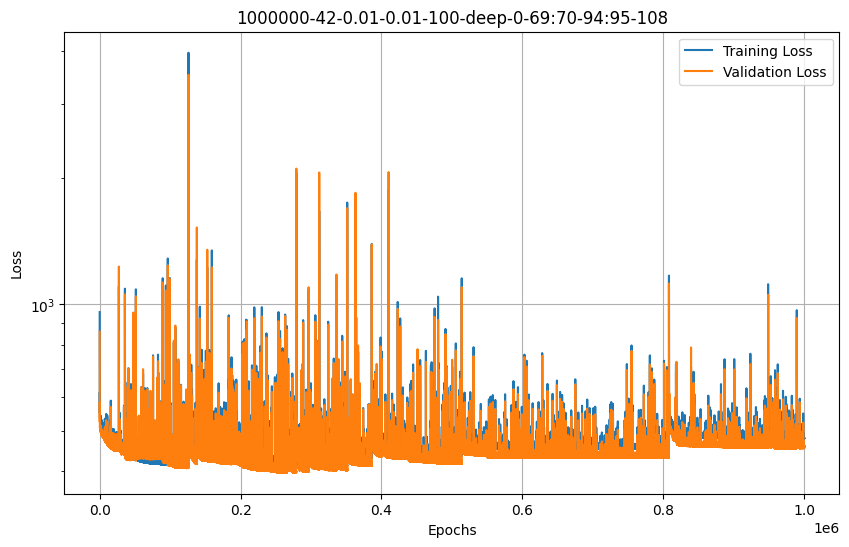

In [8]:
# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results["training_losses"], label='Training Loss')
plt.plot(range(epochs), results["validation_losses"], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title(suffix)
plt.legend()
plt.grid()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_loss_{suffix}.png'))

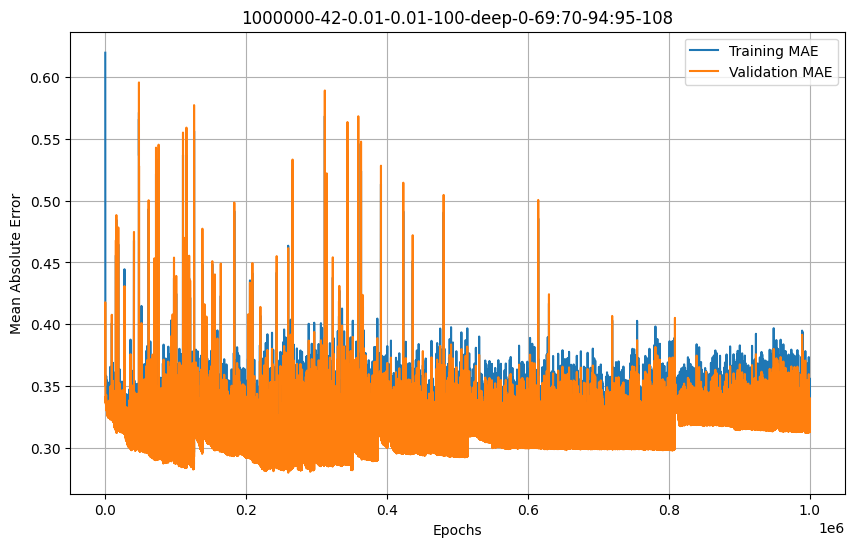

In [9]:
# Plot the training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results["training_acc"], label='Training MAE')
plt.plot(range(epochs), results["validation_acc"], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
# plt.ylim(0.8, 1.0)
plt.title(suffix)
plt.legend()
plt.grid()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_acc_{suffix}.png'))

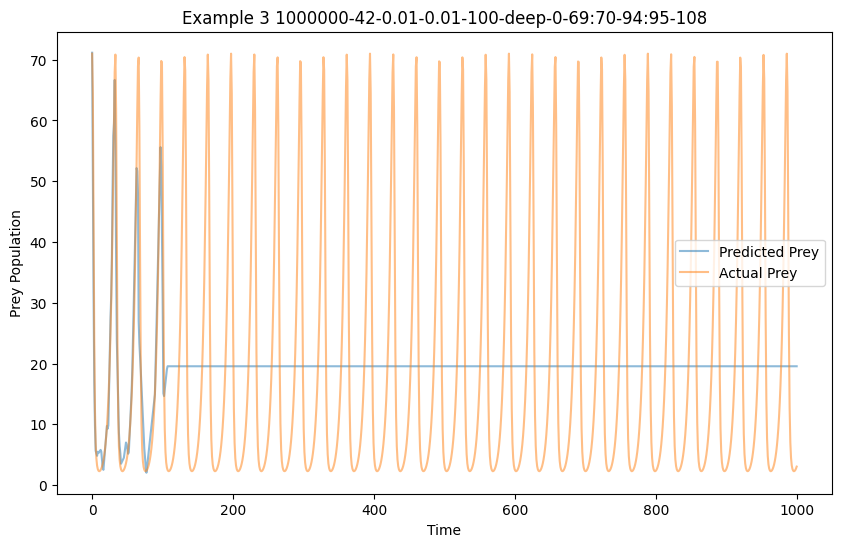

In [10]:
i = 3
n = 1000

plt.figure(figsize=(10, 6))
plt.plot(range(n), test_outputs[(i*n):(i+1)*n,:][:,0], label="Predicted Prey", alpha=0.5)
plt.plot(range(n), testing_data['labels'][(i*n):(i+1)*n,:][:,0], label="Actual Prey", alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.title(f"Example {i} {suffix}")
plt.legend()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_prey_{suffix}.png'))

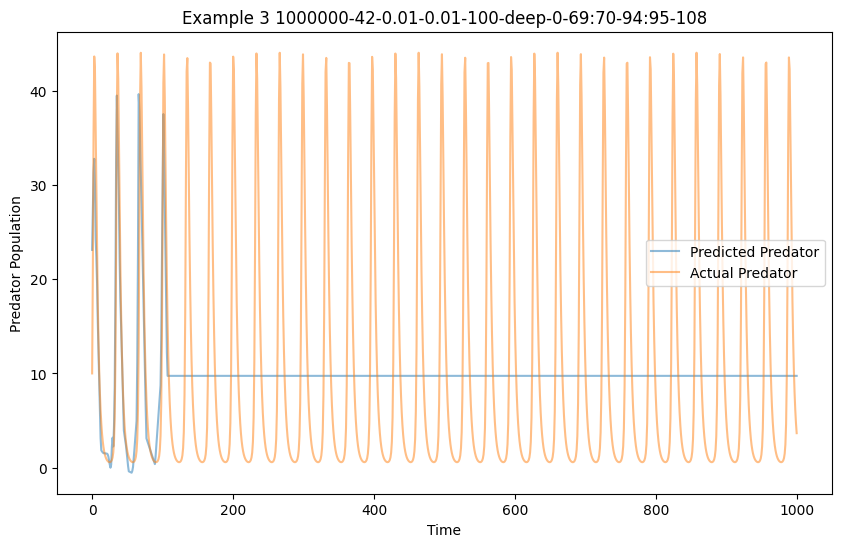

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(n), test_outputs[(i*n):(i+1)*n,:][:,1], label="Predicted Predator", alpha=0.5)
plt.plot(range(n), testing_data['labels'][(i*n):(i+1)*n,:][:,1], label="Actual Predator", alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Predator Population')
plt.title(f"Example {i} {suffix}")
plt.legend()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_predator_{suffix}.png'))